**Kyle Ayisi Project 1 Report**

#### General instructions

**This Project is due by 11:00pm EST on Friday March 8.** Please submit **both a .pdf and a .ipynb** files on Gradescope by the deadline.

For all parts of this assignment, **all code *and outputs* should be visible on both the .pdf and .ipynb files**. Please **annotate your code**.  Please do not round the outputs of your code.  **When reporting numerical findings in the *narrative part* of your report, please round answers to an appropriate number of digits.  This usually means having 4 decimal places (e.g., 45.7186); however, if the answer has a lot of leading zeros (e.g., 0.000034), you might want to include 4 or more non-zero digits. Just make sure that you do not report answers in long strings of numbers (e.g., 5.043289); this will make your report look unprofessional.**  **Remember not to round intermediate calculations.**  Please answer all questions in complete sentences.  You answers should demonstrate that you are able to interpret the outputs of your code and your analysis follows a logical flow.  Please advoid hardcoding.  For example, if the dataset for the assignment was updated with additional rows, your code should still work without any modifications.  

----

Please type your name after "Digitally signed:" below the honor pledge to serve as digital signature(s).

> I pledge my honor that I have not violated the honor code when completing this assignment.

Digitally signed: Kyle Ayisi

----

In [1]:
import matplotlib.pyplot as plt # for making basic graphs
import seaborn as sns # seaborn is an extension of matplotlib; it is used to make more advanced graphs

import pandas as pd # for manipulating dataframes
import numpy as np # for manipulating arrays
from tqdm import tqdm  # Progress bar for for-loops
import random

from sklearn import metrics # for computing accuracy, AUC-ROC score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LogisticRegression # for building logistic models
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier, plot_tree

from scipy.stats import uniform, truncnorm, randint

from sklearn.ensemble import RandomForestClassifier


# **Overview**

In this project we will build a Logistic model and a Random Forest (RF) model to predict whether a customer will default on a loan (i.e., to identify the loans in the "bad" category of the good.bad variable). We will use the dataset good_bad_loans.csv. This dataset has 1,303,286, rows and 18 columns. Please see variable definitions.pdf for the definitions of the variables in the dataset.

# **Exploratory Data Analysis**

In [2]:
loandf = pd.read_csv('/content/good_bad_loans.csv')

In [3]:
#Learn about the dataset
loandf.head(3)
#numeric statistics and columns
print('dataset shape = ' + str(loandf.shape)) #1,303,286 customers, 18 variables per customer
print('dataset columns = ' + str(loandf.columns)) #column for each variable that might be relevant to model
loandf.info() #data types for each variable

#Value counts of target variable
loandf['good_bad'].value_counts() #note that good has approx 4x as much as bad

dataset shape = (1303286, 18)
dataset columns = Index(['funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'purpose', 'addr_state', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'application_type', 'acc_now_delinq',
       'delinq_amnt', 'tax_liens', 'good_bad'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303286 entries, 0 to 1303285
Data columns (total 18 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   funded_amnt       1303286 non-null  int64  
 1   term              1303286 non-null  object 
 2   int_rate          1303286 non-null  float64
 3   installment       1303286 non-null  float64
 4   grade             1303286 non-null  object 
 5   emp_length        1228127 non-null  object 
 6   home_ownership    1303286 non-null  object 
 7   annual_inc        1303286 non-null  float64
 8   purpose           1303286 non-null  object 
 

good    1041663
bad      261623
Name: good_bad, dtype: int64

In [4]:
print('Ratio of good:bad class sizes = ' + str(loandf[loandf['good_bad'] == 'good'].shape[0] / loandf[loandf['good_bad'] == 'bad'].shape[0]))

Ratio of good:bad class sizes = 3.981542142701521


At first look, the dataset has 1,303,286 rows, each corresponding to a different customer of the online lending platform. The 18 columns correspond to variables about the customers, such as their home state, the purpose for their loan, and how much they received for the loan.

A look at the class sizes tells us we have 1,041,663 customers in the good class and 261,623 in the bad class. This means that there is 1 customer in the 'bad' data class for approximately every 4 in the 'good' class, which makes this dataset quite imbalanced. To ensure that our model is not skewed by the large proportion of the majority class, we can conduct a random downsampling. We can sample a random customer from the good class without replacement until the good class is equal to the bad class. This helps balance out our dataset.

In [5]:
#conduct downsampling

#new loan dataframe for downsampled data
newloandf = pd.DataFrame()

#split original into good and bad classes
good_df = loandf[loandf['good_bad'] == 'good']
bad_df = loandf[loandf['good_bad'] == 'bad']

#sample from majority class to reach count same as that of minority
random_good = good_df.sample(bad_df.shape[0], random_state=2024)

#concatenate dfs together for new downsampled df
newloandf = pd.concat([newloandf, random_good], ignore_index=True)
newloandf = pd.concat([newloandf, bad_df], ignore_index=True)

#check values of each class after downsample
print(newloandf['good_bad'].value_counts())
print('Ratio of good:bad class sizes = ' + str(newloandf[newloandf['good_bad'] == 'good'].shape[0] / newloandf[newloandf['good_bad'] == 'bad'].shape[0]))

good    261623
bad     261623
Name: good_bad, dtype: int64
Ratio of good:bad class sizes = 1.0


This downsampled dataframe now contains equal proportions of both classes and is much more balanced. There are now 261,623 customers in each class (for a total of 523,246 datapoints) and we can proceed with more exploratory data analysis with this dataset. Note that a random state (2024) was used for the purposes of reproducibility, so though the rows selected are random, these random rows will be selected each time the code is run.

Next, we want to check the percentage of data missing for each variable. We can do this by searching for null values in the now reduced dataset.

In [6]:
#Percentage of null values
for column in newloandf.columns:
  nullpct = newloandf[column].isnull().sum()/newloandf.shape[0] * 100
  print(column + ' percentage of null values = ' + str(round(nullpct, 4)))
  if nullpct > 0:
    print(newloandf[column].isnull().groupby(newloandf['good_bad']).value_counts(normalize=True, dropna=False).round(4))

funded_amnt percentage of null values = 0.0
term percentage of null values = 0.0
int_rate percentage of null values = 0.0
installment percentage of null values = 0.0
grade percentage of null values = 0.0
emp_length percentage of null values = 6.5168
good_bad  emp_length
bad       False         0.9223
          True          0.0777
good      False         0.9474
          True          0.0526
Name: emp_length, dtype: float64
home_ownership percentage of null values = 0.0
annual_inc percentage of null values = 0.0
purpose percentage of null values = 0.0
addr_state percentage of null values = 0.0
dti percentage of null values = 0.0
delinq_2yrs percentage of null values = 0.0
inq_last_6mths percentage of null values = 0.0
application_type percentage of null values = 0.0
acc_now_delinq percentage of null values = 0.0
delinq_amnt percentage of null values = 0.0
tax_liens percentage of null values = 0.0
good_bad percentage of null values = 0.0


The dataset is complete for the most part, with the exception of the employment length variable, for which 6.52% of customers are missing data. More specifically, of those who fully paid off their loans (good), 5.26% of customers are missing employment length data, and for those who defaulted (bad), 7.77% are missing employment data. There are a variety of ways to deal with this, such as removing the missing datapoints or using different methods to assign values to the null points, but I will add these missing values to their own category within the employment length variable.

The next thing to do is to create some plots to visualize the relationships between our categorical and numeric variables. This will help us start to understand what variables might influence our target variable (whether or not an individual defaults on their loan) the most.

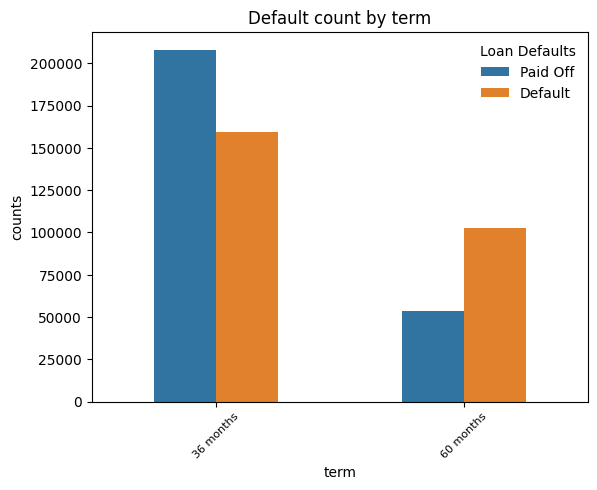

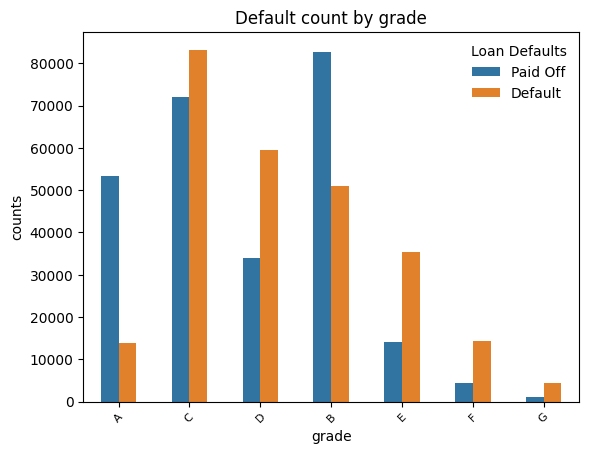

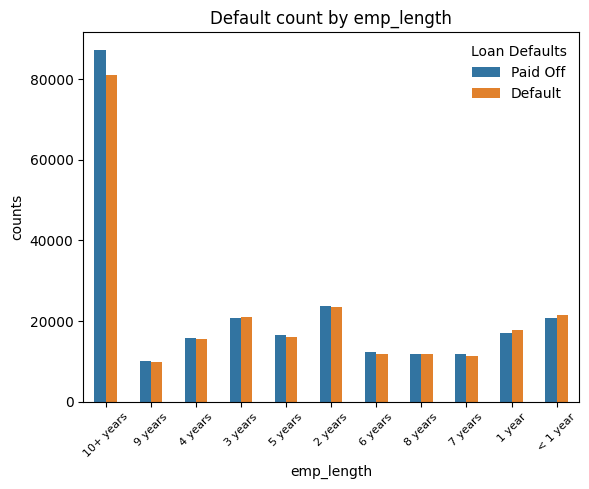

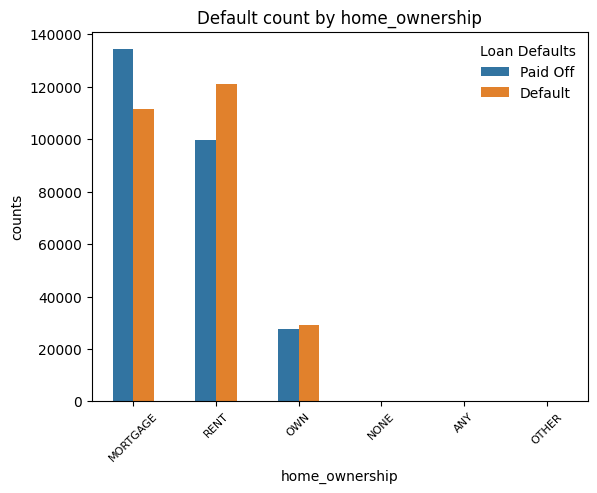

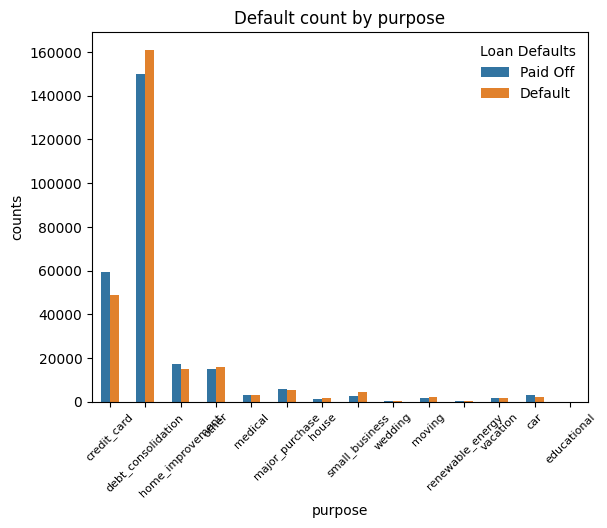

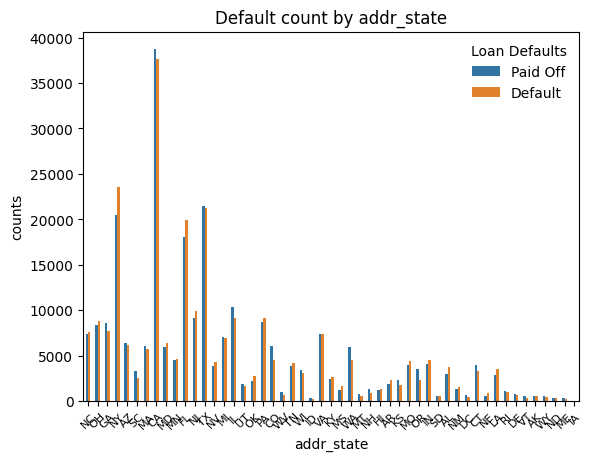

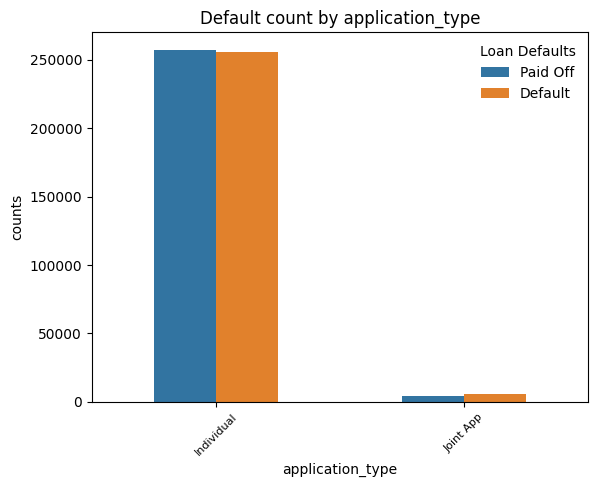

In [7]:
loan_catvar = newloandf.select_dtypes(include=object)
loan_catvar['good_bad'] = loan_catvar['good_bad'].replace(['good', 'bad'], [0, 1])
loan_catvar

for column in loan_catvar.columns[:-1]:
  cat_plot = sns.countplot(loan_catvar, x = column, hue = 'good_bad', width=0.5)
  cat_plot.set(title='Default count by ' + column,
               ylabel = 'counts')
  plt.legend(title = "Loan Defaults",
             labels=['Paid Off', 'Default'],  framealpha=0)
  plt.xticks(rotation=45, fontsize=8)
  plt.show()

We learn a lot about the data by looking at these categorical countplots. They let us know the number of customers who fall into the good or bad class based off of the category they fall into for each categorical variables. An eye test of these plots can imply some useful information. For instance, the count based on application type plot shows that for both applicants who apply for an individual or joint loan, there is not much of a difference in how many default or pay off their loan. This could clue us in to the idea that application type actually doesn't have much correlation with default probability. Another example is the grade plot. Although we do not necessarily know the lending platform's grading system, we can see that from A-F the proportions follow a trend. With the background domain knowledge I have, this makes sense. It makes sense that of those who receive an A grade, a large proportion pay off their loan, and that proportion decreases as the grade decreases.

It's good to see the counts before we change the plots to show proportions because this gives us an introductory idea of what variables could have higher importance than others, but also because it shows us what categories could potentially be combined within a variable. Categories with similar proportions can likely be combined to make our model more efficient. Additionally, showing counts allows us to take note of variables with very low counts that might not shift our function and model very much.

Normalization can help make our graph easier to read and give us more exact percentages to make those combination decisions with. This is what we will do next.

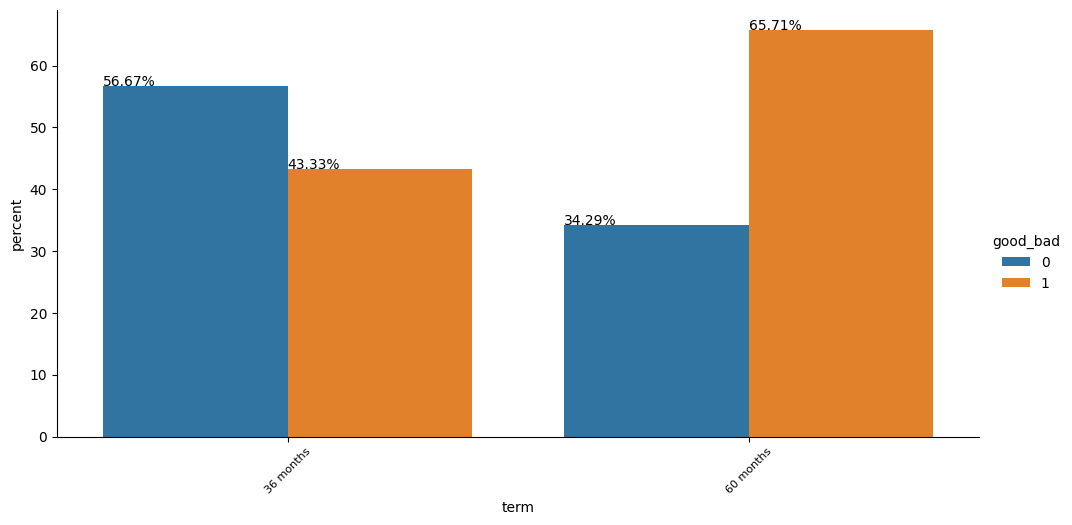

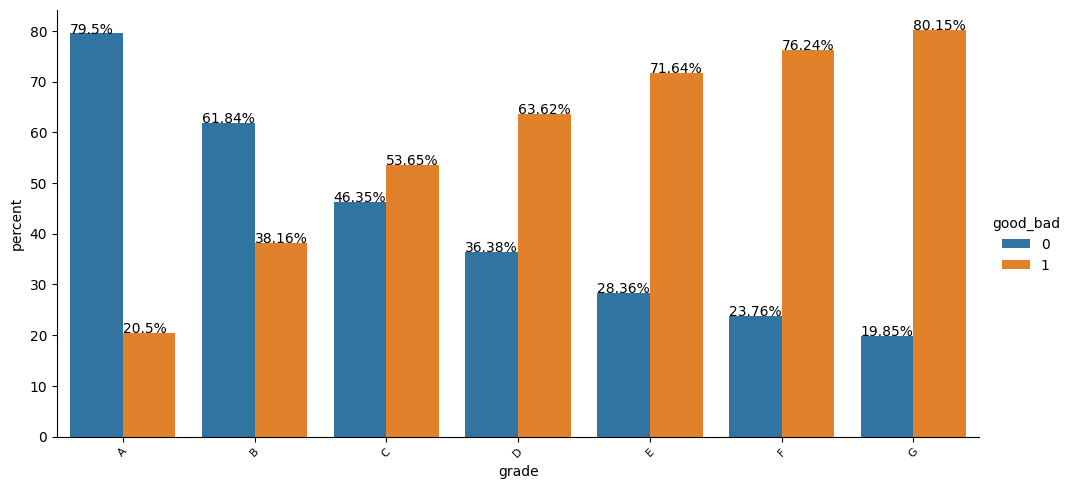

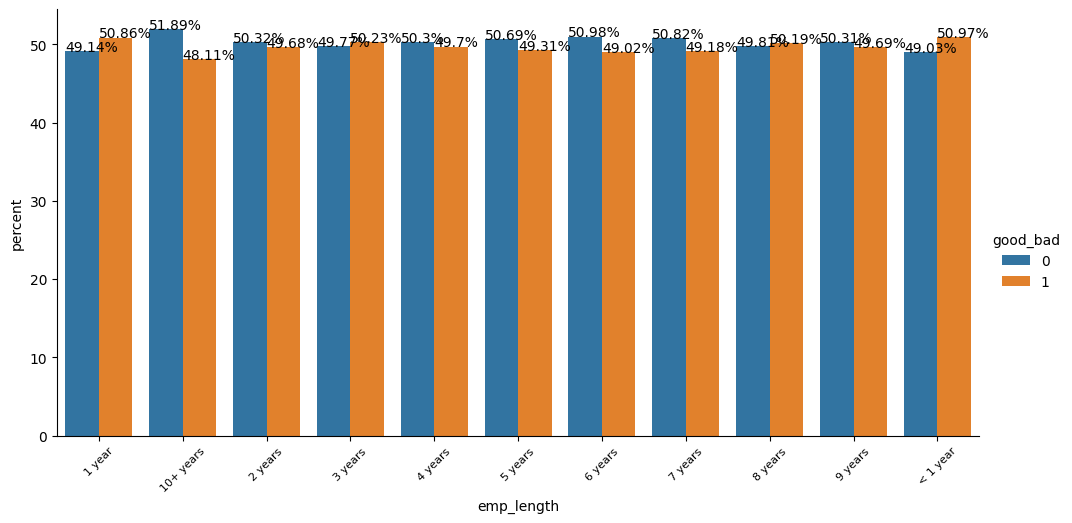

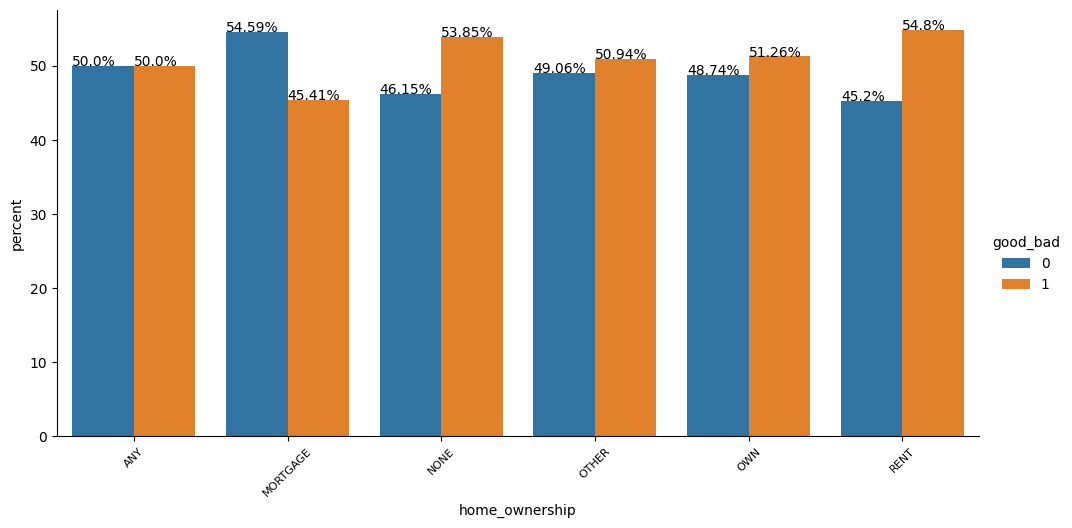

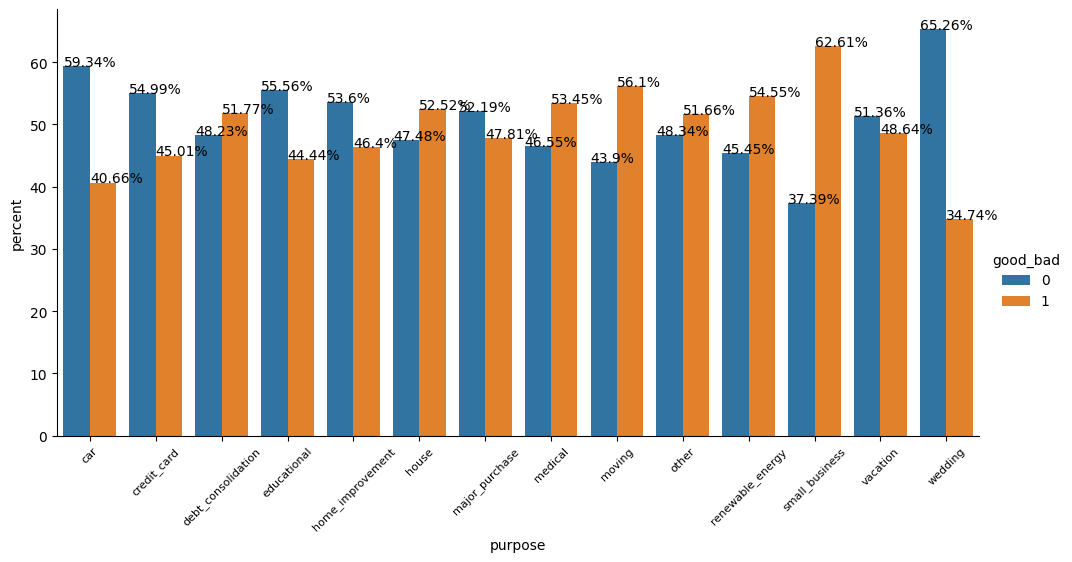

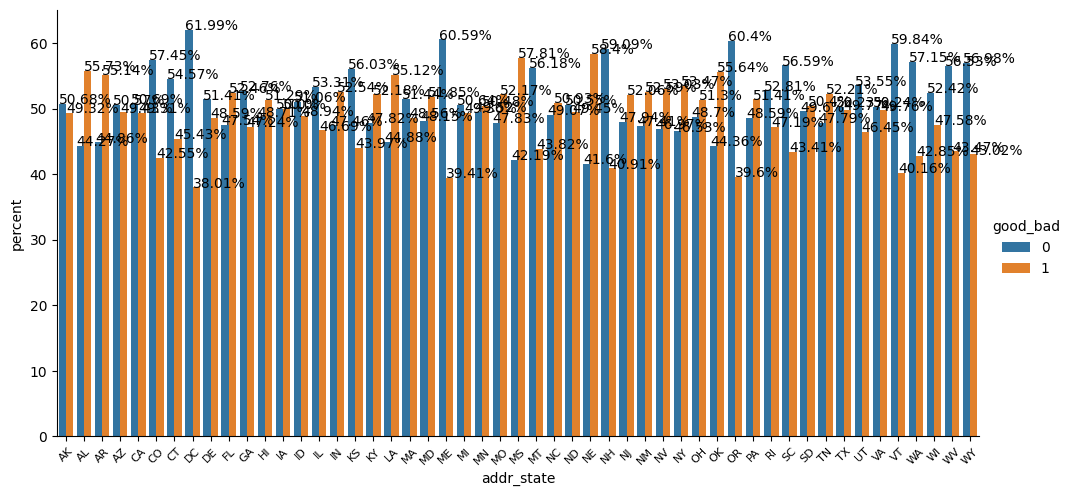

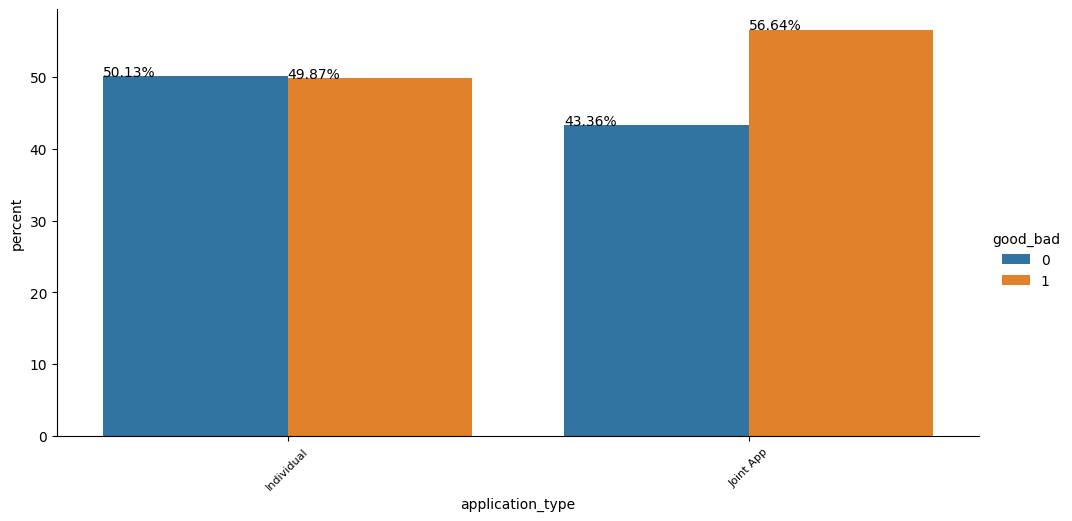

In [8]:
for column in loan_catvar.columns[:-1]:
  prop = loan_catvar.groupby(column)['good_bad'].value_counts(normalize = True)
  proppct = prop*100
  proppct_df = proppct.reset_index(name = 'percent')
  proppct_df1 = proppct_df.sort_values([column, 'good_bad'])
  k = sns.catplot(x=column, y='percent',hue='good_bad',kind='bar',
                data=proppct_df1, height=5, aspect=2)
  plt.xticks(rotation=45, fontsize=8)
  for p in k.ax.patches[0:(len(k.ax.patches)-2)]:
    txt = str(round(p.get_height(), 2)) + '%'
    #round(..., 2) rounds the input to 2 digits after the decimal
    txt_x = p.get_x()
    txt_y = p.get_height()
    k.ax.text(txt_x,txt_y,txt)
  plt.show()

These plots are helpful in understanding which categories within a variable may be able to be combined. This is helpful because combining categories helps to reduce the number you are looking at, making a model and its outputs a bit more readable and interpretable. There is of course the chance that you might be lumping together categories that contain certain nuances in predicting an output and should actually remain separate, but in this case it is helful in reducing our predictors and the complexity of our model.

This analysis of categorical variables is helpful, but we also want to take a look at our numerical variables and once again get an idea of what variables might be most impactful when it comes to predicting a good or bad customer.

In [9]:
loan_numvar = newloandf.select_dtypes(include=int)
loan_numvar['good_bad'] = newloandf['good_bad']
loan_numvar['good_bad'] = loan_numvar['good_bad'].replace(['good', 'bad'], [0, 1])

In [10]:
loan_numvar

,funded_amnt,delinq_2yrs,inq_last_6mths,acc_now_delinq,delinq_amnt,tax_liens,good_bad
0,10000,0,0,0,0,0,0
1,25000,0,0,0,0,0,0
2,15000,0,0,0,0,1,0
3,8325,1,1,0,0,0,0
4,10000,0,0,0,0,0,0
...,...,...,...,...,...,...,...
523241,30000,0,1,0,0,0,1
523242,30000,0,2,0,0,0,1
523243,20700,0,0,0,0,0,1
523244,30000,0,1,0,0,0,1


We have replaced bad, our target class, with 1, and good with 0. We will now sample 50,000 customers and plot the pairgrid to get an idea for how these various numeric variables are distributed across the good and bad class.

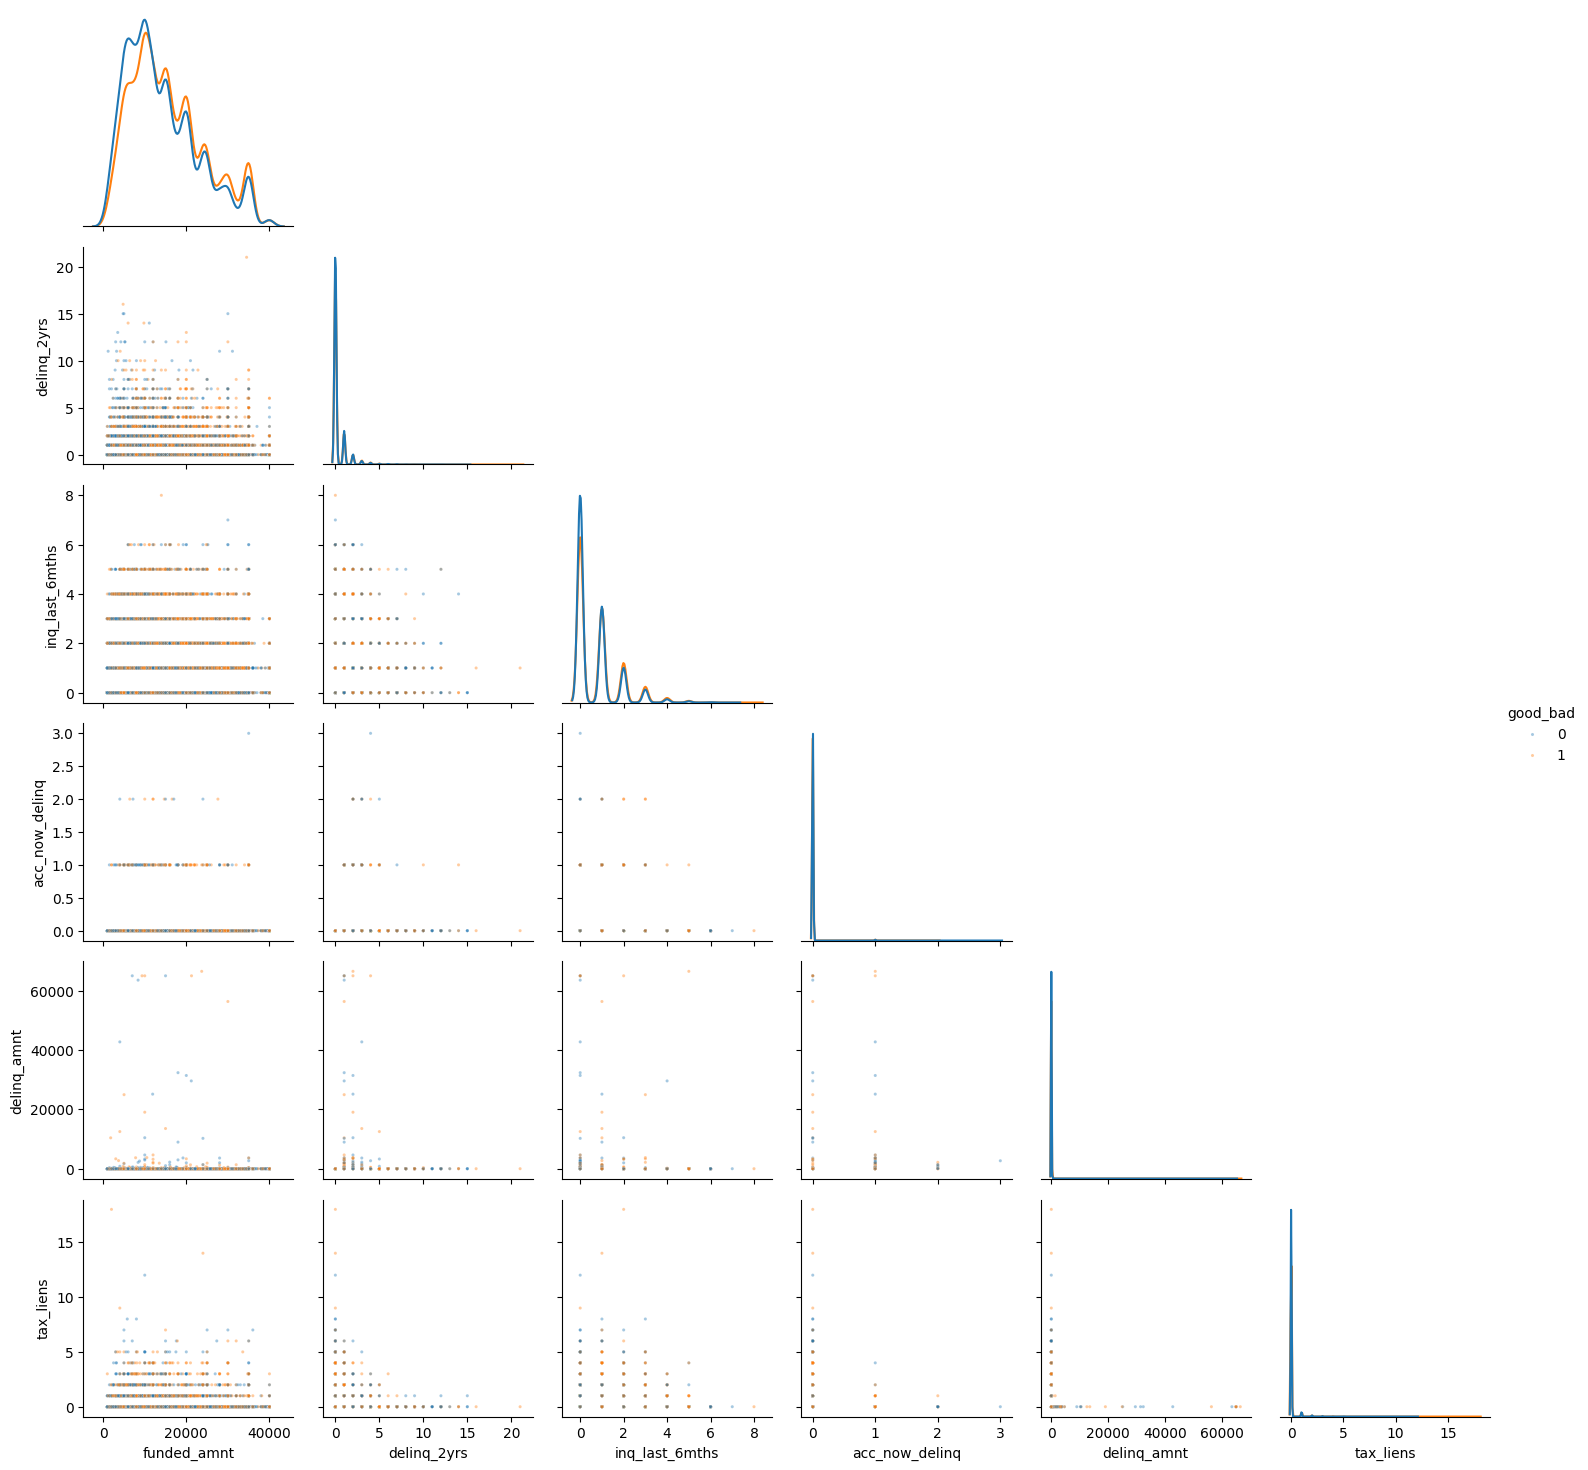

In [11]:
rand_numvar = loan_numvar.sample(50000, random_state=2024)
e = sns.PairGrid(rand_numvar, hue="good_bad", diag_sharey = False, corner = True)
e.map_diag(sns.kdeplot)
e.map_lower(sns.scatterplot, s = 5, alpha = .4) # s for size
e.add_legend()

This pairgrid shows us the relationships between our numeric variables. Between the classes, we can see that the most separation is in the funded amount variable, indicating that this might be the continuous variable with the most influence on how the good and bad classes trend. The separation is good because distributions that heavily overlap could indicate that in regards to that specific variable, there might not be enough distinction for a model to make accurate predictions and distinguish between one class or another.

For the categorical variables, we are again looking for this separation that a model could use to make a solid prediction. In this case, it seems our top categorical variables are the grade given to a customer and the term length of the loan. With this, we are now ready to construct our models.

# **Methods**

We are first going to finish cleaning up the data before we split the data and build the models. The dataset is balanced, so as mentioned before, we will finish off the cleaning by putting any null values into their own category. As we said in the EDA, only employment length has null values, so we will set all of those null values equal to a new category, "NA".

In [12]:
newloandf['emp_length'].unique()
newloandf.loc[newloandf['emp_length'].isnull(), 'emp_length'] = 'NA'
newloandf['emp_length'].value_counts()

10+ years    168225
2 years       47267
< 1 year      42418
3 years       41682
1 year        34788
NA            34099
5 years       32607
4 years       31237
6 years       24189
8 years       23639
7 years       23148
9 years       19947
Name: emp_length, dtype: int64

Next, we will want to combine categories to increase interpretability for variables with more categories within them, and categories that have very similar proportions within a variable. First, we will check three eligible variables: employment length, purpose, and state. We want to check out the percentage of bad accounts in the categories within these variables. We have basically done this in our EDA, but will print it again more specifically for these categories.

In [ ]:
reduce_catvar = newloandf[['emp_length', 'purpose','addr_state', 'good_bad']]
for column in reduce_catvar.columns[:-1]:
  prop = reduce_catvar.groupby(column)['good_bad'].value_counts(
      normalize = True)
  proppct = prop*100
  proppct_df = proppct.reset_index(name='percent')
  proppct_df1 = proppct_df.sort_values([column, 'good_bad'])
  proppct_df1 = proppct_df1[proppct_df1['good_bad'] == 'bad'].sort_values(
      by=['percent'])
  print(proppct_df1)
  k = sns.catplot(x=column, y='percent',hue='good_bad',kind='bar',
                data=proppct_df1, height=5, aspect=2)
  plt.xticks(rotation=45, fontsize=8)
  for p in k.ax.patches[0:(len(k.ax.patches)-2)]:
    txt = str(round(p.get_height(), 2)) + '%'
    #round(..., 2) rounds the input to 2 digits after the decimal
    txt_x = p.get_x()
    txt_y = p.get_height()
    k.ax.text(txt_x,txt_y,txt)
  plt.show()


With these outputs, we can get an idea of what categories have similar importance in predicting a customer who will default. Percentages similar to each other likely can be combined because the class follows similar behavior between those categories within the variable. For instance, in employment length, there are a sequence of lengths that fall within 1 percent of each other. The categories of that sequence that are close to each other chronologically could make sense to combine because there may be no difference, for instance, between someone employed 3 years and someone employed 4 years, while there is a difference between those individuals and someone employed under 1 year. Using this logic, I will make the following combinations with the following justifications:


*   2-9 years of employment all fall within 1.2% of each other, 1 year and less than 1 year have identical percentages, and 10+ years and the NA category fall a bit outside these ranges so employment length will have the following categories: <=1 year, 2-9 years, 10>= years, and NA. These categories make sense with knowledge of the trustworthiness of a loan applicant based on how long they have been able to hold down a job.
*   The following combinations: [house, medical], [renewable energy, moving], [debt consolidation, other], [educational, credit card, home improvement], [major purchase, vacation] will be made. These variables fall very close to each other percentage-wise. The potential negative side of this set of combinations is that the variables sometimes may not have a lot to do with each other, so if a combination happens to influence the target variable heavily, it will be ambiguous as to which of the variables in a combination might really be the impactful player. For now, however, we will use these combinations. Any variable not mentioned will be in a group by itself.
*   The following states combinations: [ME, OR, VT, NH], [CO, WA, WY, SC, WV, MT, KS], [CT, UT, IL, RI, GA, WI], [MA, DE, ID], [CA, AK, MI, AZ, ND, VA, TX], [IA, SD, MN, NC, HI, OH, PA, MD], [NJ, MO, KY, TN, FL, IN, NM, NV, NY], [LA, AR, OK, AL] will be made. MS, NE, and DC will be alone.

These combinations will hopefully simplify the model and make results easier to read.





In [14]:
#state combinations
newloandf['addr_statecom'] = newloandf['addr_state']
newloandf.loc[newloandf['addr_statecom'].isin(['ME', 'OR', 'VT', 'NH']),
              'addr_statecom'] = 'statecombo_1'
newloandf.loc[newloandf['addr_statecom'].isin(['CO', 'WA', 'WY', 'SC', 'WV',
                                               'MT', 'KS']),
               'addr_statecom'] = 'statecombo_2'
newloandf.loc[newloandf['addr_statecom'].isin(['CT', 'UT', 'IL', 'RI',
                                               'GA', 'WI']),
               'addr_statecom'] = 'statecombo_3'
newloandf.loc[newloandf['addr_statecom'].isin(['MA', 'DE', 'ID']),
              'addr_statecom'] = 'statecombo_4'
newloandf.loc[newloandf['addr_statecom'].isin(['CA', 'AK', 'MI', 'AZ', 'ND',
                                               'VA', 'TX']),
               'addr_statecom'] = 'statecombo_5'
newloandf.loc[newloandf['addr_statecom'].isin(['IA', 'SD', 'MN', 'NC', 'HI',
                                               'OH', 'PA', 'MD']),
               'addr_statecom'] = 'statecombo_6'
newloandf.loc[newloandf['addr_statecom'].isin(['NJ', 'MO', 'KY', 'TN', 'FL',
                                               'IN', 'NM', 'NV', 'NY']),
               'addr_statecom'] = 'statecombo_7'
newloandf.loc[newloandf['addr_statecom'].isin(['LA', 'AR', 'OK', 'AL']),
              'addr_statecom'] = 'statecombo_8'

#purpose combinations
newloandf['purpose_com'] = newloandf['purpose']
newloandf.loc[newloandf['purpose_com'].isin(['house', 'medical']),
              'purpose_com'] = 'purposecombo_1'
newloandf.loc[newloandf['purpose_com'].isin(['renewable_energy', 'moving']),
              'purpose_com'] = 'purposecombo_2'
newloandf.loc[newloandf['purpose_com'].isin(['debt_consolidaton', 'other']),
              'purpose_com'] = 'purposecombo_3'
newloandf.loc[newloandf['purpose_com'].isin(['educational', 'credit_card',
                                             'home_improvement']),
               'purpose_com'] = 'purposecombo_4'
newloandf.loc[newloandf['purpose_com'].isin(['major_purchase', 'vacation']),
              'purpose_com'] = 'purposecombo_5'

#emp_length combinations
newloandf['emp_lengthcom'] = newloandf['emp_length']
newloandf.loc[newloandf['emp_lengthcom'].isin(['< 1 year', '1 year']),
              'emp_lengthcom'] = 'maximum 1 year'
newloandf.loc[newloandf['emp_lengthcom'].isin(['2 years', '3 years', '4 years',
                                               '5 years', '6 years', '7 years',
                                               '8 years', '9 years']),
               'emp_lengthcom'] = '2-9 years'

newloandf_orig = newloandf
newloandf_orig
newloandf = newloandf.drop(columns=['purpose', 'emp_length', 'addr_state'])

In [15]:
newloandf

,funded_amnt,term,int_rate,installment,grade,home_ownership,annual_inc,dti,delinq_2yrs,inq_last_6mths,application_type,acc_now_delinq,delinq_amnt,tax_liens,good_bad,addr_statecom,purpose_com,emp_lengthcom
0,10000,36 months,6.03,304.36,A,MORTGAGE,55000.0,10.08,0,0,Individual,0,0,0,good,statecombo_6,purposecombo_4,10+ years
1,25000,60 months,13.18,571.14,C,RENT,60000.0,13.50,0,0,Individual,0,0,0,good,statecombo_6,debt_consolidation,2-9 years
2,15000,36 months,7.26,464.95,A,MORTGAGE,48000.0,18.15,0,0,Individual,0,0,1,good,statecombo_3,purposecombo_4,2-9 years
3,8325,36 months,13.65,283.12,C,RENT,29000.0,21.90,1,1,Individual,0,0,0,good,statecombo_7,debt_consolidation,2-9 years
4,10000,36 months,5.32,301.15,A,MORTGAGE,94000.0,10.72,0,0,Individual,0,0,0,good,statecombo_5,debt_consolidation,2-9 years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523241,30000,60 months,30.17,973.74,F,MORTGAGE,75856.0,20.71,0,1,Individual,0,0,0,bad,statecombo_5,purposecombo_4,10+ years
523242,30000,36 months,21.45,1137.20,D,MORTGAGE,94000.0,25.76,0,2,Individual,0,0,0,bad,statecombo_3,debt_consolidation,10+ years
523243,20700,60 months,12.62,466.98,C,OWN,46000.0,27.05,0,0,Individual,0,0,0,bad,statecombo_7,debt_consolidation,10+ years
523244,30000,60 months,17.09,747.03,D,RENT,80000.0,23.22,0,1,Individual,0,0,0,bad,statecombo_7,debt_consolidation,2-9 years


We are now ready to build the Random Forest model, which can give us an idea of the variables' predictive power.

In [16]:
# build X dataframe

#numeric variables
newloandf['good_bad'] = newloandf['good_bad'].replace(['good', 'bad'], [0, 1])

X_numeric = newloandf.select_dtypes(include=int).drop(['good_bad'], axis=1)
X_numeric

numericlist = X_numeric.columns
numericlist

#dummies
dummies = pd.get_dummies(newloandf.select_dtypes(include=object))

X = pd.concat([X_numeric, dummies], axis = 1)
X

,funded_amnt,delinq_2yrs,inq_last_6mths,acc_now_delinq,delinq_amnt,tax_liens,term_36 months,term_60 months,grade_A,grade_B,...,purpose_com_purposecombo_2,purpose_com_purposecombo_3,purpose_com_purposecombo_4,purpose_com_purposecombo_5,purpose_com_small_business,purpose_com_wedding,emp_lengthcom_10+ years,emp_lengthcom_2-9 years,emp_lengthcom_NA,emp_lengthcom_maximum 1 year
0,10000,0,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
1,25000,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,15000,0,0,0,0,1,1,0,1,0,...,0,0,1,0,0,0,0,1,0,0
3,8325,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,10000,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523241,30000,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
523242,30000,0,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
523243,20700,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
523244,30000,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
#create y dataframe
y = newloandf['good_bad']

In [18]:
X_nontest, X_test, y_nontest, y_test = train_test_split(X, y,
                                                        test_size=0.4,
                                                        random_state=2024,
                                                        stratify = y)

Above is the creation of the X and y sets, test and nontest. The X dataframe is created by combining the numeric variables (excluding the target variable) and the categorical variables, transformed into dummy variables. The

In [19]:
#RF model

#hyperparameter defining
hyperparameters = {'n_estimators':[x for x in range(100, 701, 250)],
                   # The number of trees in the forest.
                   'min_samples_split': [x for x in range(5, 45, 3)],
                   # The minimum number of samples required to
                   'n_jobs' : [-1],
                   # Number of jobs to run in parallel.
                   #-1 means using all processors.
                   'random_state' : [2024],
                   'max_features': [x for x in range(1, 15, 2)],
                   # The number of features to consider when
                    #looking for the best split
                   'oob_score' : [True] #use out-of-bag samples
                   #to estimate the generalization score
                  }

# Initialize a random forest classifier
rf = RandomForestClassifier()

# Perform randomized search cross-validation to find the best hyperparameters
randomized_search = RandomizedSearchCV(estimator=rf,
                                       param_distributions=hyperparameters,
                                       n_iter=10,
                                       # Number of parameter settings that are sampled
                                       cv=5, # folds of the cross-validations
                                       n_jobs = -1,
                                       random_state=2024)
randomized_search.fit(X_nontest, y_nontest)



/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_features': [1, 3, 5, 7, 9, 11, 13],
                                        'min_samples_split': [5, 8, 11, 14, 17,
                                                              20, 23, 26, 29,
                                                              32, 35, 38, 41,
                                                              44],
                                        'n_estimators': [100, 350, 600],
                                        'n_jobs': [-1], 'oob_score': [True],
                                        'random_state': [2024]},
                   random_state=2024)

In [20]:
best_hyperparameters = randomized_search.best_params_
best_rf = RandomForestClassifier(**best_hyperparameters)
print(best_rf)
best_rf.fit(X_nontest, y_nontest)

RandomForestClassifier(max_features=7, min_samples_split=44, n_estimators=600,
                       n_jobs=-1, oob_score=True, random_state=2024)


RandomForestClassifier(max_features=7, min_samples_split=44, n_estimators=600,
                       n_jobs=-1, oob_score=True, random_state=2024)

In [21]:
y_pred = best_rf.predict(X_test)
y_pred
accuracy = metrics.accuracy_score(y_test, y_pred)

In [22]:
print("Estimated accuracy = " + str(accuracy))

Estimated accuracy = 0.6384072546930468


This model uses the following hyperparameters and achieves a 64% accuracy score: maximum 7 features considered when looking for best split, 44 minimum datapoints to create a split in a variable, and 600 trees.

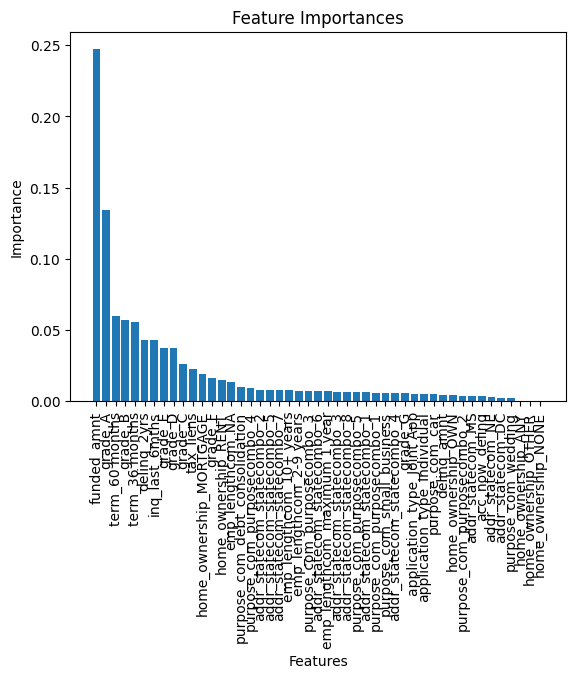

In [23]:
#find and plot the importance of different categories within variables
importances = best_rf.feature_importances_
importances

sorted_indices = importances.argsort()[::-1]
sorted_indices

plt.bar(range(X.shape[1]), [importances[i] for i in sorted_indices])
plt.xticks(range(X.shape[1]),
           [X.columns[i] for i in sorted_indices],
           rotation=90)
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

This plot shows us the features and their relative importance to predicting the target variable. We can see from this graph that the funded amount, an A grade, a term of 60 months, a grade of B, and a term of 36 months are the top 5 predictors. home_ownership_none, home_ownership_other, home_ownership_any, borrowing for a wedding, and being from DC are the bottom 5 predictors in terms of their importance value.

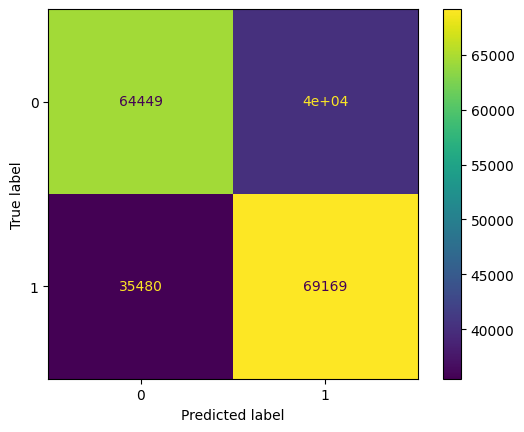

In [24]:
confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

The confusion matrix displays the model's accuracy for both classes. On the x-axis we see the label the model predicted, 1 for a bad customer and 0 for a good customer. The y-axis is the true label, or what a customer really was. The higher on the scale the color of the square is, the higher the accuracy. We can see that the model has considerably high rates of predicting the correct label.

We can now use the most predictive variables to perform logistic regression.

In [25]:
threshold = importances[0] * (.05)
thresh_importance = importances[importances > threshold]
importances = thresh_importance

In [26]:
print(newloandf['funded_amnt'].corr(newloandf['installment']))

0.9493172702606172


We first want to drop variables with low predictive performance in our RF model. We drop any variables whose importance values are less than 5% of that of the funded amount variable, our most important. We also drop the installment variable, which has very high correlation with the funded amount variable as shown above. Using these final variables, we will conduct our logistic regression with a LASSO penalty.

In [27]:
X_nontest, X_test, y_nontest, y_test = train_test_split(X, y, test_size=0.3, random_state=2024)

In [28]:
#standardize data
scaler = StandardScaler().fit(X_nontest[numericlist])

# transform nontest and test sets with the parameters
X_nontest[numericlist] = scaler.transform(X_nontest[numericlist])

X_test[numericlist] = scaler.transform(X_test[numericlist])

X_nontest

,funded_amnt,delinq_2yrs,inq_last_6mths,acc_now_delinq,delinq_amnt,tax_liens,term_36 months,term_60 months,grade_A,grade_B,...,purpose_com_purposecombo_2,purpose_com_purposecombo_3,purpose_com_purposecombo_4,purpose_com_purposecombo_5,purpose_com_small_business,purpose_com_wedding,emp_lengthcom_10+ years,emp_lengthcom_2-9 years,emp_lengthcom_NA,emp_lengthcom_maximum 1 year
125118,-0.780462,-0.366726,0.303580,-0.067178,-0.017903,-0.126609,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
458324,-1.066400,-0.366726,0.303580,-0.067178,-0.017903,-0.126609,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
344038,0.592037,-0.366726,0.303580,-0.067178,-0.017903,-0.126609,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
181341,2.307661,0.738055,-0.724726,-0.067178,-0.017903,-0.126609,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0
175416,-1.123587,-0.366726,1.331886,-0.067178,-0.017903,-0.126609,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178715,0.683537,-0.366726,-0.724726,-0.067178,-0.017903,-0.126609,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
428672,-0.551713,-0.366726,0.303580,-0.067178,-0.017903,-0.126609,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
51808,2.307661,-0.366726,1.331886,-0.067178,-0.017903,-0.126609,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
314874,-1.409525,-0.366726,-0.724726,-0.067178,-0.017903,-0.126609,1,0,1,0,...,0,0,1,0,0,0,0,1,0,0


In [29]:
#create folds for cross validation
cv = StratifiedKFold(n_splits=3, # number of splits
                     random_state=2024, # set seed for the randomization
                     shuffle=True) # shuffle each stratification of the data
                                   # before splitting into batches

list(cv.split(X_nontest, y_nontest))

[(array([     0,      1,      4, ..., 366266, 366268, 366270]),
  array([     2,      3,      5, ..., 366267, 366269, 366271])),
 (array([     0,      2,      3, ..., 366268, 366269, 366271]),
  array([     1,      4,     16, ..., 366262, 366263, 366270])),
 (array([     1,      2,      3, ..., 366269, 366270, 366271]),
  array([     0,      6,      7, ..., 366261, 366266, 366268]))]

In [30]:
lambdas = np.logspace(-3, 1, num=20)
lambdas

params = {"C":1/lambdas, "penalty":["l1"]}

model = LogisticRegression(class_weight='balanced', solver='saga', penalty="l1",
                           max_iter=1000)



grid_search_cv = GridSearchCV(estimator = model,
                              param_grid = params,
                              scoring= 'roc_auc',
                              cv = cv,
                              return_train_score=True, verbose = 1)

In [31]:
best_model = grid_search_cv.fit(X_nontest, y_nontest)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

In [32]:
cv_results = pd.DataFrame(grid_search_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,196.751886,43.106815,0.058992,0.000813,1000.0,l1,"{'C': 1000.0, 'penalty': 'l1'}",0.703473,0.701859,0.703403,0.702911,0.000745,6,0.702833,0.703601,0.702854,0.703096,0.000357
1,194.516143,42.131139,0.058920,0.000753,615.848211,l1,"{'C': 615.8482110660267, 'penalty': 'l1'}",0.703473,0.701859,0.703403,0.702911,0.000745,4,0.702833,0.703601,0.702854,0.703096,0.000357
2,194.037574,41.054058,0.058045,0.000999,379.269019,l1,"{'C': 379.26901907322497, 'penalty': 'l1'}",0.703473,0.701859,0.703403,0.702911,0.000745,3,0.702833,0.703601,0.702854,0.703096,0.000357
3,192.940320,41.599290,0.057291,0.000776,233.572147,l1,"{'C': 233.57214690901213, 'penalty': 'l1'}",0.703473,0.701859,0.703402,0.702911,0.000745,8,0.702833,0.703601,0.702854,0.703096,0.000357
4,193.769830,41.753295,0.061702,0.007162,143.844989,l1,"{'C': 143.8449888287663, 'penalty': 'l1'}",0.703473,0.701859,0.703402,0.702911,0.000745,9,0.702833,0.703601,0.702854,0.703096,0.000357
5,196.050615,40.490448,0.059849,0.001152,88.586679,l1,"{'C': 88.58667904100828, 'penalty': 'l1'}",0.703473,0.701859,0.703402,0.702911,0.000745,7,0.702833,0.703601,0.702854,0.703096,0.000357
6,195.313131,40.046492,0.060087,0.002154,54.555948,l1,"{'C': 54.5559478116852, 'penalty': 'l1'}",0.703473,0.701859,0.703402,0.702911,0.000745,5,0.702833,0.703601,0.702854,0.703096,0.000357
7,201.459993,39.331804,0.066072,0.005620,33.598183,l1,"{'C': 33.59818286283783, 'penalty': 'l1'}",0.703473,0.701859,0.703403,0.702911,0.000745,1,0.702833,0.703601,0.702854,0.703096,0.000357
8,196.376723,44.072739,0.058038,0.000955,20.691381,l1,"{'C': 20.6913808111479, 'penalty': 'l1'}",0.703473,0.701859,0.703402,0.702911,0.000745,2,0.702833,0.703601,0.702854,0.703096,0.000357
9,193.975301,41.738519,0.064941,0.004729,12.74275,l1,"{'C': 12.74274985703134, 'penalty': 'l1'}",0.703473,0.701859,0.703402,0.702911,0.000745,10,0.702833,0.703601,0.702854,0.703096,0.000357


In [33]:
print("Tuned Hyperparameters :", grid_search_cv.best_params_)
print("AUC :",grid_search_cv.best_score_)

s = pd.to_numeric(cv_results['param_C'], errors='coerce')
s

Tuned Hyperparameters : {'C': 33.59818286283783, 'penalty': 'l1'}
AUC : 0.7029113251642491


0     1000.000000
1      615.848211
2      379.269019
3      233.572147
4      143.844989
5       88.586679
6       54.555948
7       33.598183
8       20.691381
9       12.742750
10       7.847600
11       4.832930
12       2.976351
13       1.832981
14       1.128838
15       0.695193
16       0.428133
17       0.263665
18       0.162378
19       0.100000
Name: param_C, dtype: float64

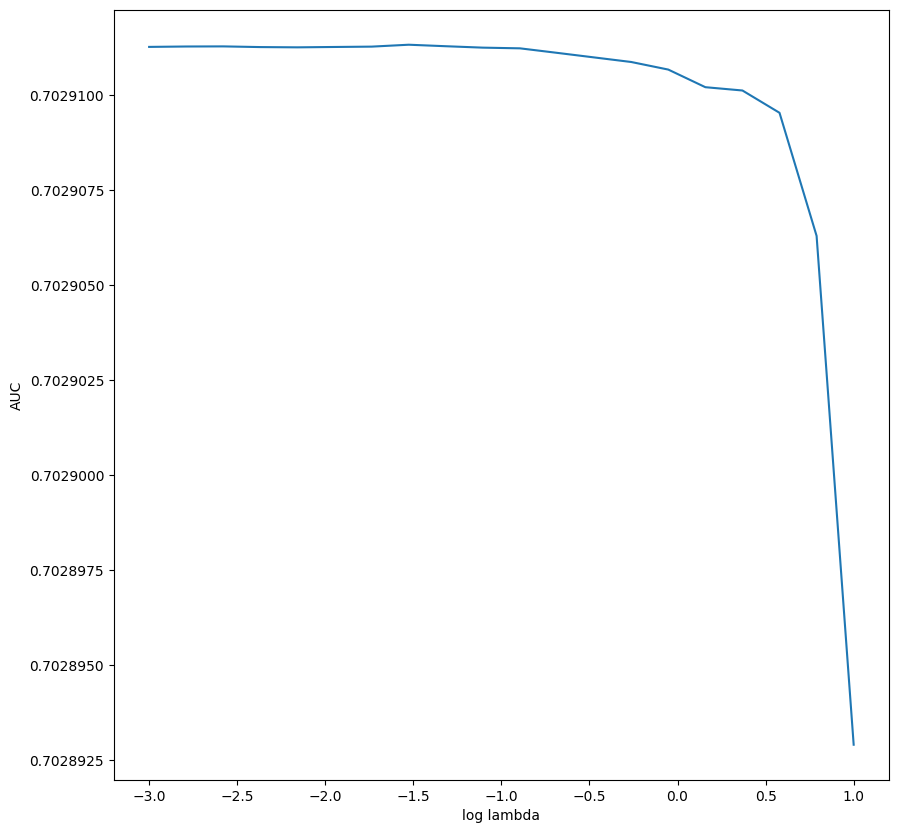

In [34]:
plt.figure(figsize=(10,10))
plt.xlabel("log lambda")
plt.ylabel("AUC")
plt.plot(np.log10(1/s),cv_results['mean_test_score'])
plt.show()

The reported AUC for this model is just over 70%.

# **Conclusion**

### Result

This logistic regression model using the variables selected for in the random forest model performs fairly well on the data and lets us know that variables such as how much a customer is asking to be loaned and the grade assigned to them are likely important in predicting whether or not they will default on a loan.

### Discussion

This model is likely not the most successful that could be made, and different changes to variables and hyperparameters can increase accuracy. Regardless of what we change, the dataset should always be balanced because an training on an imbalanced dataset will create a model that is biased towards whichever class has the majority, and could improperly categorize new data.

We created a random forest classifier, which differs from bagging in that it randomly selects some of the variables to create split, as shown in the max_features hyperparameter.

RF is great at creating boundaries and splits that are not linear, while logistic regression has less flexibility in this regard. Logistic regression might outperform RF if the relationship between the target and variables tested is fairly linear and the groups are very distinct from each other.

In the presented hypothetical situation, if this variable has a low importance value, it does not necessarily mean that the model thinks that datapoints in that variable have a low chance of having bad credit. A low importance value simply means that relative to other variables, the model does not think that variable plays as much of a role in distinguishing one group from the other. It is less important to the separation between the groups.

-Kyle Ayisi

